# Analysis of Shock Series Data

This notebook analyzes shock series data from an Excel file, tests for normality, and creates histograms with probability density function overlays.

In [ ]:
# Install packages (uncomment and run only once if you haven't installed these packages)
#using Pkg
#Pkg.add(["XLSX", "DataFrames", "Plots", "StatsPlots", "Statistics", "Distributions", "HypothesisTests"])

In [24]:
# Load required packages
using XLSX
using DataFrames
using Plots
using StatsPlots
using Statistics
using Distributions
using HypothesisTests

## Read and Prepare Data

Define a function to read the Excel file with specific handling for our requirements.

In [149]:
"""
Read Excel data with specific handling requirements:
- Skip first empty row
- Use second row as column headers
- Include columns B to M, but exclude column C
- Handle "#I/T" values by treating them as missing
"""
function read_excel_series(file_path="shockseries.xlsx")
    
    # Prep dict
    series_dfs = Dict()

    # Read the Excel file
    xlsx_file = XLSX.readxlsx(file_path)
    
    for i in 1:2
        sheet = xlsx_file[i]  
        
        # Read the entire data range including headers
        data_range = sheet[:]
        
        # Extract column headers from the second row (row index 2)
        headers = data_range[2, :]
        
        # Create a DataFrame from data, starting from row 3
        df_all = DataFrame(data_range[3:end, :], Symbol.(headers))
        
        # Identify columns to keep (B to M, excluding C in sheet 1)
        # Column A contains dates (index 1) C is missing in sheet 1
        if i == 1
            keep_cols = [2, 4:13...]  # Columns C is missing in sheet 1
        else
            keep_cols = [2:13...] 
        end

        # Extract only the columns we want
        df_filtered = df_all[:, keep_cols]

        for col in names(df_filtered)
            # Create a new dataframe for this series
            series_df = DataFrame()
            
            # Copy column values with proper handling of problematic values
            series_df[!, :value] = map(df_filtered[!, col]) do val
                if val isa String && (val == "#I/T" || val == "" || val == "NA")
                    return missing
                elseif val isa Missing
                    return missing
                elseif val == 0 || val == "0" || val == "0.0"
                    return missing
                else
                    # Try to convert to Float64, if it fails return missing
                    try
                        return parse(Float64, string(val))
                    catch
                        return missing
                    end
                end
            end
            
            # Remove rows with missing values
            series_df = dropmissing(series_df)
            
            # Store this processed series
            series_dfs[string(col)] = series_df
        end
    end

    return series_dfs
end;

## Basic Statistics

Calculate and display basic statistics for each series.

In [151]:
"""
Generate basic statistics for a data series
"""
function print_statistics(series_value, series_name)
    data = series_value
    println("\n==== Basic Statistics for '$series_name' ====")
    println("Count: $(length(data))")
    println("Min: $(minimum(data))")
    println("Max: $(maximum(data))")
    println("Mean: $(mean(data))")
    println("Median: $(median(data))")
    println("Standard Deviation: $(std(data))")
end;

In [152]:
basic_stats = Dict()

for (key, _) in series_dict
    basic_stats[key] = print_statistics(series_dict["$key"].value, key)
end;


==== Basic Statistics for 'FischerPeters' ====
Count: 196
Min: -0.3193079999999999
Max: 0.24257999999999996
Mean: 0.0055001568316326525
Median: 0.007171500000000053
Standard Deviation: 0.08636944873203505

==== Basic Statistics for 'BHsupply' ====
Count: 515
Min: -9.78667768186261
Max: 4.59889777076531
Mean: -0.04839799993717003
Median: -0.0274482082663075
Standard Deviation: 1.6463402881032898

==== Basic Statistics for 'BassetLoan' ====
Count: 76
Min: -1.97
Max: 2.67
Mean: 0.005000000000000012
Median: -0.19
Standard Deviation: 0.9998499887483123

==== Basic Statistics for 'KurmanOtrokNews' ====
Count: 181
Min: -6.08010333601241
Max: 3.23228273821476
Mean: 2.3945333131917435e-13
Median: 0.050495234731374
Standard Deviation: 1.0027739304327548

==== Basic Statistics for 'Bloom' ====
Count: 522
Min: -34.4613255592894
Max: 94.1243331564761
Mean: -4.874101973454975e-12
Median: -1.839460732943225
Standard Deviation: 15.196190794028198

==== Basic Statistics for 'KilianAERSupply' ====
Coun

## Normality Testing

Test each series for normality using Shapiro-Wilk and Kolmogorov-Smirnov tests.

In [153]:
"""
Test if a data series follows a normal distribution
"""
function test_normality(series_value, series_name)
    data = series_value
    #println("\n==== Normality Tests for '$series_name' ====")
    
    # Shapiro-Wilk test
    sw_test = ShapiroWilkTest(data)
    
    # Kolmogorov-Smirnov test
    μ = mean(data)
    σ = std(data)
    ks_test = ExactOneSampleKSTest(data, Normal(μ, σ))
    
    # Print results
    #println("Shapiro-Wilk Test:")
    #println("W = $(sw_test.W), p-value = $(pvalue(sw_test))")
    #println("$(pvalue(sw_test) < 0.05 ? "Reject" : "Fail to reject") null hypothesis of normality at 5% significance level")
    
    #println("\nKolmogorov-Smirnov Test:")
    #println("D = $(ks_test.δ), p-value = $(pvalue(ks_test))")
    #println("$(pvalue(ks_test) < 0.05 ? "Reject" : "Fail to reject") null hypothesis of normality at 5% significance level")
    
    # Print skewness and kurtosis
    skew = skewness(data)
    kurt = kurtosis(data)
    #println("\nSkewness: $(round(skew, digits=3)) (0 for normal distribution)")
    #println("Excess Kurtosis: $(round(kurt, digits=3)) (0 for normal distribution)")
    
    return (shapiro_wilk=sw_test, kolmogorov_smirnov=ks_test, skewness=skew, kurtosis=kurt)
end

test_normality

In [141]:
test_results = Dict()

for (key, _) in series_dict
    test_results[key] = test_normality(series_dict["$key"].value, key)
end;

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\cjw\.julia\packages\HypothesisTests\4N1Zy\src\kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\cjw\.julia\packages\HypothesisTests\4N1Zy\src\kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\cjw\.julia\packages\HypothesisTests\4N1Zy\src\kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\cjw\.julia\packages\HypothesisTests\4N1Zy\src\kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\cjw\.julia\packages\HypothesisTests\4N1Zy\src\kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\cjw\.julia\packages\HypothesisTests\4N1Zy\src\kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\cjw\.julia\packages\HypothesisTests\4N1Zy\src\kolmogorov

## Visualization

Create histograms with normal PDF overlays for each series.

In [154]:
"""
Create histogram with PDF overlay for a data series
"""
function plot_histogram_with_pdf(data; title="Distribution Analysis")

    # Create histogram
    h = histogram(data, 
                 normalize=true,
                 alpha=0.6,
                 label="Histogram", 
                 title=title,
                 xlabel="Value", 
                 ylabel="Density")
    
    # Add kernel density estimate
    density!(h, data, label="KDE", line=(:black, 2), legend=:topright)
    
    return h
end;

In [155]:
# Create individual plots for each series
individual_plots = Dict()

for (series_name, _) in series_dict
    individual_plots[series_name] = plot_histogram_with_pdf(
        series_dict["$series_name"].value, 
        title="Distribution of $series_name"
    )
    #display(individual_plots[series_name])
end

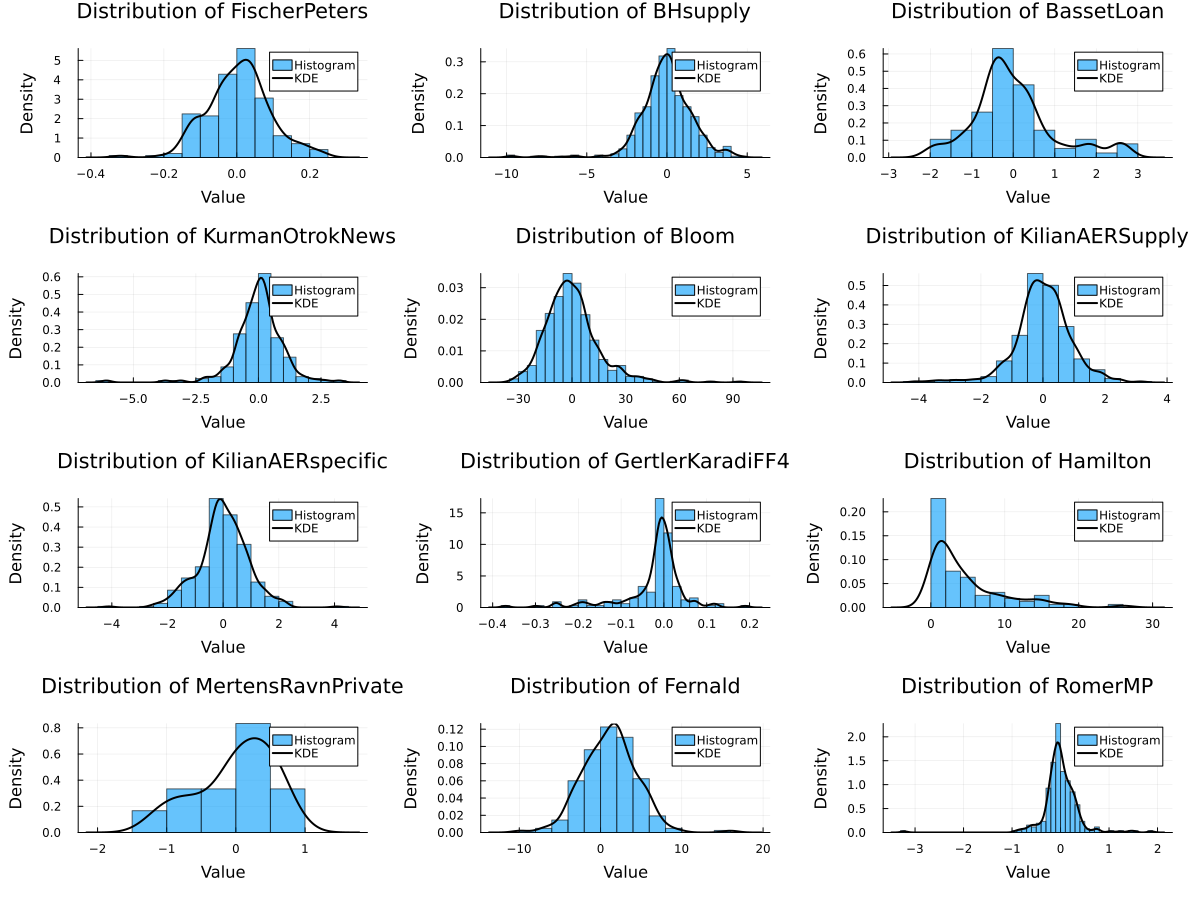

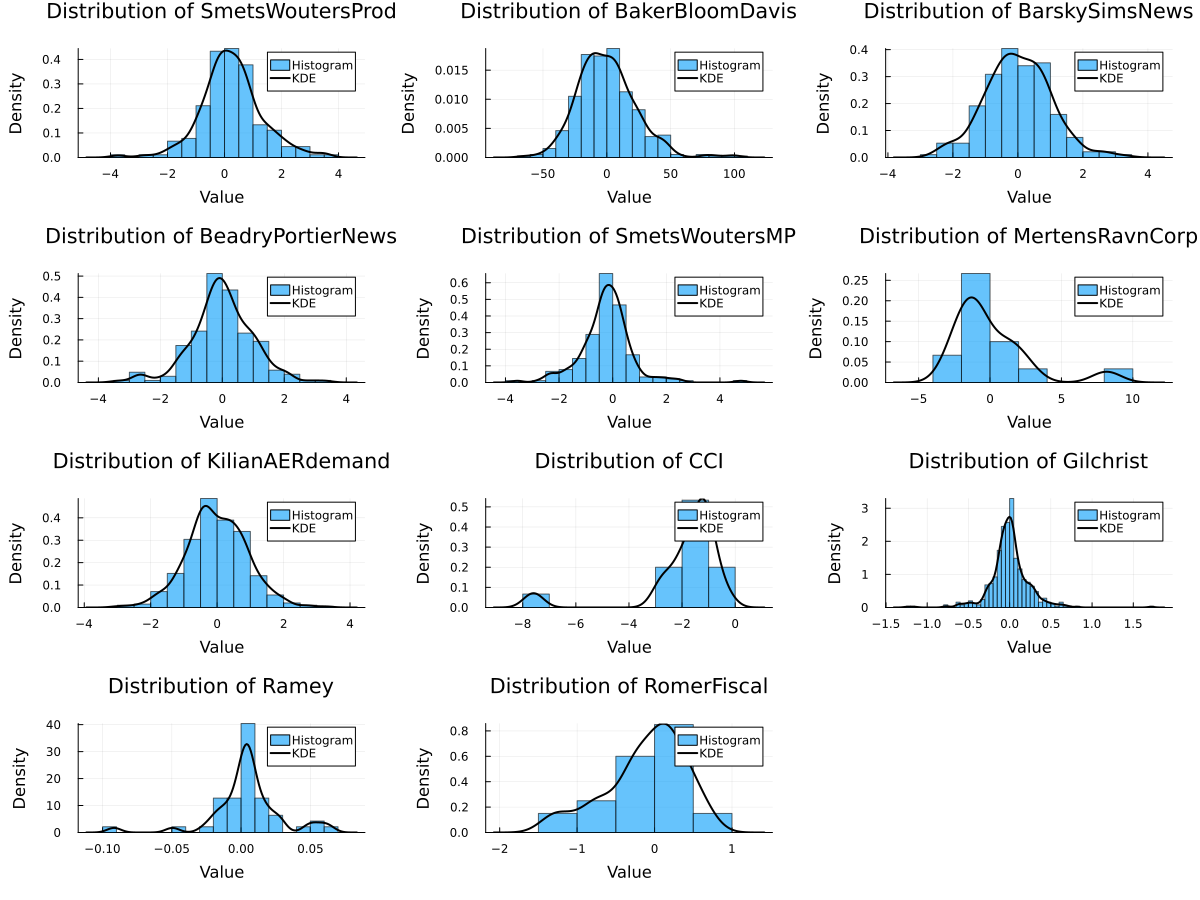

In [156]:
# Convert the dictionary values to an array first
all_plots_array = collect(values(individual_plots))

# First combined figure with 12 plots
final_plot1 = plot(all_plots_array[1:12]..., 
                  layout=(4, 3), 
                  size=(1200, 900), 
                  margin=5Plots.mm)

# Display the first combined plot
display(final_plot1)

# Save the first combined plot
savefig(final_plot1, "combined_series_distributions_1.png")

# Second combined figure with the remaining 11 plots
final_plot2 = plot(all_plots_array[13:23]..., 
                  layout=(4, 3),  # This will have one empty spot
                  size=(1200, 900), 
                  margin=5Plots.mm)

# Display the second combined plot
display(final_plot2)

# Save the second combined plot
savefig(final_plot2, "combined_series_distributions_2.png");

## Summary of Normality Tests

Create a summary table with all normality test results.

In [157]:
# Create a summary table
normality_summary = DataFrame(
    Series = String[],
    SW_Statistic = Float64[],
    SW_PValue = Float64[],
    KS_Statistic = Float64[],
    KS_PValue = Float64[],
    Skewness = Float64[],
    Kurtosis = Float64[],
    Is_Normal = String[]
)

for (series_name, series_df) in series_dict
    result = test_results[series_name]
    is_normal = (pvalue(result.shapiro_wilk) > 0.05 && 
                 pvalue(result.kolmogorov_smirnov) > 0.05) ? "Yes" : "No"
    
    push!(normality_summary, (
        series_name,
        result.shapiro_wilk.W,
        pvalue(result.shapiro_wilk),
        result.kolmogorov_smirnov.δ,
        pvalue(result.kolmogorov_smirnov),
        result.skewness,
        result.kurtosis,
        is_normal
    ))
end

# Display the summary table
normality_summary

Row,Series,SW_Statistic,SW_PValue,KS_Statistic,KS_PValue,Skewness,Kurtosis,Is_Normal
,String,Float64,Float64,Float64,Float64,Float64,Float64,String
1,FischerPeters,0.989957,0.187004,0.0472816,0.75494,-0.0405136,0.671042,Yes
2,BHsupply,0.917618,3.81379e-16,0.0744898,0.00624251,-1.18331,6.37612,No
3,BassetLoan,0.932569,0.000565401,0.122572,0.187463,0.814131,0.869547,No
4,KurmanOtrokNews,0.894892,5.22383e-10,0.1006,0.0477662,-1.35805,8.20657,No
5,Bloom,0.923707,1.29432e-15,0.0925106,0.000244399,1.3973,4.90684,No
6,KilianAERSupply,0.95906,4.92207e-9,0.0749017,0.0225502,-0.557401,2.75044,No
7,KilianAERspecific,0.981152,5.03874e-5,0.0637625,0.0771174,-0.147762,1.78686,No
8,GertlerKaradiFF4,0.596595,8.35849e-27,0.318518,9.86385e-30,-2.87145,13.6451,No
9,Hamilton,0.317481,4.48894e-39,0.450239,1.51685e-91,5.01273,29.4781,No
